In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_data():
    from sklearn.datasets import make_blobs
    X, _ = make_blobs(n_samples=1000, centers=3, n_features=10, random_state=42)

    rng = np.random.RandomState(42)
    X[:20] = rng.uniform(low=-10, high=10, size=(20, 10))
    return pd.DataFrame(X, columns=[f'sensor_{i}' for i in range(10)])

In [3]:

def preprocess_data(data):
    numeric_data = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    return scaled_data, numeric_data.columns

In [4]:

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")
    
    return principal_components, pca

In [6]:

def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)

    anomaly_percentage = np.sum(clusters == -1) / len(clusters) * 100
    
    print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
    print(f"Anomaly percentage: {anomaly_percentage:.2f}%")
    
    return clusters, anomaly_percentage

In [8]:

def plot_results(pca_data, clusters):
    plt.figure(figsize=(10, 8))
    
    plot_df = pd.DataFrame({
        'PC1': pca_data[:, 0],
        'PC2': pca_data[:, 1],
        'cluster': clusters
    })

    normal_points = plot_df[plot_df['cluster'] != -1]
    if not normal_points.empty:
        sns.scatterplot(
            data=normal_points,
            x='PC1', y='PC2',
            hue='cluster',
            palette='viridis',
            alpha=0.7,
            legend='full'
        )
    anomalies = plot_df[plot_df['cluster'] == -1]
    if not anomalies.empty:
        sns.scatterplot(
            data=anomalies,
            x='PC1', y='PC2',
            color='red',
            marker='X',
            s=100,
            label='Anomaly'
        )
    
    plt.title('DBSCAN Clustering with PCA (Anomalies in Red)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:

def calculate_custom_metric(clusters, pca_data):
    """
    Custom metric combining:
    1. Percentage of anomalies (weight: 40%)
    2. Silhouette score for non-anomaly points (weight: 60%)
    """
    if len(set(clusters)) > 1:
        non_anomaly_mask = clusters != -1
        if sum(non_anomaly_mask) > 1: 
            silhouette = silhouette_score(pca_data[non_anomaly_mask], clusters[non_anomaly_mask])
        else:
            silhouette = 0
    else:
        silhouette = 0
    
    anomaly_percentage = np.sum(clusters == -1) / len(clusters)
    
    custom_score = 0.6 * silhouette + 0.4 * (1 - anomaly_percentage)
    
    print(f"\nCustom Metric Evaluation:")
    print(f"Silhouette Score (non-anomaly points): {silhouette:.4f}")
    print(f"Anomaly Percentage: {anomaly_percentage:.4f}")
    print(f"Custom Combined Score: {custom_score:.4f}")
    
    return custom_score

In [10]:

def generate_anomaly_report(data, original_data, clusters):
    anomalies_mask = clusters == -1
    anomalies = original_data[anomalies_mask]
    
    print("\n=== Anomaly Analysis Report ===")
    print(f"Total data points: {len(original_data)}")
    print(f"Anomalies detected: {len(anomalies)} ({len(anomalies)/len(original_data)*100:.2f}%)")
    
    if len(anomalies) > 0:
        print("\nCharacteristics of anomalies:")
        normal_stats = original_data[~anomalies_mask].mean()
        anomaly_stats = anomalies.mean()
        
        comparison = pd.DataFrame({
            'Normal_Mean': normal_stats,
            'Anomaly_Mean': anomaly_stats,
            'Difference': anomaly_stats - normal_stats
        })
        
        print("\nFeature comparison (anomalies vs normal points):")
        print(comparison.sort_values('Difference', key=abs, ascending=False))
        print("\nTop 5 most extreme anomalies (by distance from cluster centers):")
    else:
        print("No anomalies detected with current parameters.")

Explained variance ratio: [0.53366936 0.34236408]
Total explained variance: 0.88
Number of clusters: 3
Anomaly percentage: 1.90%


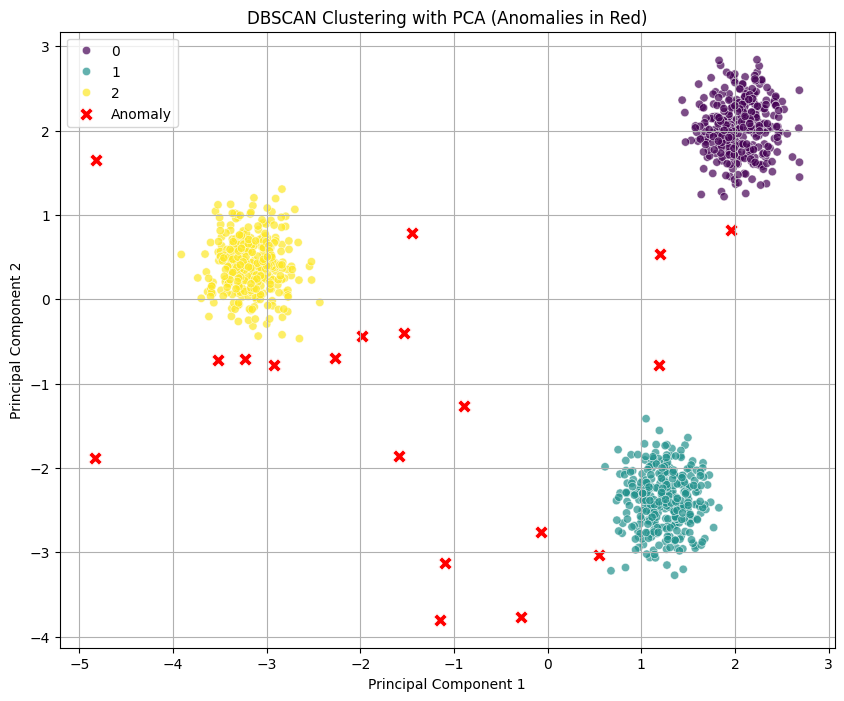


Custom Metric Evaluation:
Silhouette Score (non-anomaly points): 0.8922
Anomaly Percentage: 0.0190
Custom Combined Score: 0.9277

=== Anomaly Analysis Report ===
Total data points: 1000
Anomalies detected: 19 (1.90%)

Characteristics of anomalies:

Feature comparison (anomalies vs normal points):
          Normal_Mean  Anomaly_Mean  Difference
sensor_6    -6.277401     -0.201722    6.075680
sensor_4    -4.682546     -0.020097    4.662449
sensor_1     3.688987     -0.512268   -4.201255
sensor_8     0.874557     -2.333556   -3.208113
sensor_0    -3.263269     -0.154802    3.108467
sensor_2     2.336191     -0.331572   -2.667762
sensor_3    -2.095885      0.129353    2.225239
sensor_7     2.641413      0.606629   -2.034784
sensor_5    -2.431405     -0.542009    1.889396
sensor_9    -3.064401     -1.624630    1.439771

Top 5 most extreme anomalies (by distance from cluster centers):


In [11]:

def main():

    raw_data = load_data()

    scaled_data, feature_names = preprocess_data(raw_data)
    
    pca_data, pca_model = apply_pca(scaled_data, n_components=2)
    
    clusters, anomaly_percentage = apply_dbscan(pca_data, eps=0.3, min_samples=5)
    plot_results(pca_data, clusters)

    custom_score = calculate_custom_metric(clusters, pca_data)
    
    generate_anomaly_report(scaled_data, raw_data, clusters)

if __name__ == "__main__":
    main()